In [1]:
import os
from pathlib import Path
path = Path(os.getcwd())
os.chdir(path.parent.absolute())

import warnings
warnings.filterwarnings('ignore')

import asyncio
import itertools
from datetime import datetime
from IPython import display
import numpy as np
import pandas as pd
import pandas_ta as ta
from datetime import datetime
import vectorbt as vbt
import plotly.graph_objects as go
import mt4_hst
%matplotlib inline

In [2]:
cheight, cwidth = 500, 1000 # Adjust as needed for Chart Height and Width
vbt.settings.set_theme("dark") # Options: "light" (Default), "dark" (my fav), "seaborn"

# Must be set
vbt.settings.portfolio["freq"] = "1D" # Daily

# Predefine vectorbt Portfolio settings
vbt.settings.portfolio["init_cash"] = 1e4
vbt.settings.portfolio["fees"] = 0.0015 # 0.25%
vbt.settings.portfolio["slippage"] = 0.0015 # 0.25%
vbt.settings.portfolio["size"] = 100
# vbt.settings.portfolio["accumulate"] = False
vbt.settings.portfolio["allow_partial"] = False

pf_settings = pd.DataFrame(vbt.settings.portfolio.items(), columns=["Option", "Value"])
pf_settings.set_index("Option", inplace=True)

print(f"Portfolio Settings [Initial]")
pf_settings

Portfolio Settings [Initial]


,Value
Option,
call_seq,default
init_cash,10000.0
size,100
size_type,amount
fees,0.0015
fixed_fees,0.0
slippage,0.0015
reject_prob,0.0
min_size,0.0


In [35]:
# Example Long Trends for the selected Asset
# * Uncomment others for exploration or replace them with your own TA Trend Strategy
def trends(df: pd.DataFrame):
    # create neccesary indicators
    df.ta.percent_return(length=1, append=True)
    df.ta.sma(50, append=True)
    df.ta.ema(10, append=True)
    df.ta.ema(20, append=True)
    df.ta.donchian(lower_length=20, upper_length=20, append=True)
    df.ta.donchian(lower_length=50, upper_length=50, append=True)
    df.ta.sma(close=df['volume'], length=20, suffix="VOLUME", append=True)
    
    # condition
    trend_cond = (
        (df['close'] > df['SMA_50'])
        & (df['EMA_10'] > df['EMA_20'])
        & (df['DCL_20_20'] > df['DCL_50_50'])
        & (df['close'] > df['EMA_20']))
    
    return trend_cond
    # return ta.ma(mamode, df.close, length=fast) > ta.ma(mamode, df.close, length=slow) # SMA(fast) > SMA(slow) "Golden/Death Cross"
#     return ta.increasing(ta.ma(mamode, df.close, length=fast)) # Increasing MA(fast)
#     return ta.macd(df.close, fast, slow).iloc[:,1] > 0 # MACD Histogram is positive

def trends_confirm_entries(df: pd.DataFrame):
    # # candle pattern
    # cdl_pattern = df.ta.cdl_pattern(
    #     name=["closingmarubozu", "marubozu", "engulfing", "longline"], 
    #     scalar=1).sum(axis=1)
    # volume_breakout = (df['volume'] >= 1.5 * ta.sma(df['volume'], 20)).astype(int)
    # df['breakout_cond'] = (
    #     (cdl_pattern * volume_breakout * (df['PCTRET_1'] > 0.04) * (df['close'] > donchian_20['DCU_20_20'].shift()))
    #     .replace(0, np.nan)
    #     .fillna(method='ffill')
    #     .fillna(0).astype(int))
    # df.loc[df['breakout_cond'] < 0, ['breakout_cond']] = 0
    # df['breakout_cond'] = df['breakout_cond'].astype(bool)

In [55]:
df = mt4_hst.read_hst("stock_env/datasets/FPT1440.hst")
df = df[(df['time'] >= '2019-01-01') & (df['time'] <= '2020-12-31')]
df.index = df['time']
df.ta.tsignals(trends(df), asbool=True, append=True)
df.tail()
df.to_csv('temp/df_signals.csv', index=False)

In [61]:
df.dropna().loc[:'2019-04-09']

,time,open,high,low,close,volume,PCTRET_1,SMA_50,EMA_10,EMA_20,DCL_20_20,DCL_50_50,breakout_cond,TS_Trends,TS_Trades,TS_Entries,TS_Exits
time,,,,,,,,,,,,,,,,,
2019-03-19,2019-03-19,23.731997,23.783365,23.475157,23.475157,914720.0,-0.010823,22.454990,23.450515,23.208927,22.678953,20.804024,True,True,1,True,False
2019-03-20,2019-03-20,23.423790,23.577892,23.244001,23.346737,797270.0,-0.005470,22.498652,23.431646,23.222052,22.678953,20.804024,True,True,0,False,False
2019-03-21,2019-03-21,23.526525,23.526525,23.166950,23.166950,825740.0,-0.007701,22.542829,23.383519,23.216804,22.678953,20.804024,True,False,-1,False,True
2019-03-22,2019-03-22,23.166950,23.321053,23.141266,23.141266,687690.0,-0.001109,22.583410,23.339473,23.209610,22.678953,21.317703,True,False,0,False,False
2019-03-25,2019-03-25,22.704638,23.115582,22.704638,22.807373,633520.0,-0.014428,22.610121,23.242728,23.171301,22.678953,21.317703,True,False,0,False,False
2019-03-26,2019-03-26,23.115582,23.115582,22.858742,22.987162,386120.0,0.007883,22.638373,23.196261,23.153764,22.678953,21.317703,True,False,0,False,False
2019-03-27,2019-03-27,23.012846,23.166950,23.012846,23.115582,589040.0,0.005587,22.665085,23.181592,23.150128,22.678953,21.317703,True,False,0,False,False
2019-03-28,2019-03-28,22.987162,23.295370,22.987162,23.192633,362360.0,0.003333,22.695905,23.183600,23.154176,22.678953,21.317703,True,True,1,True,False
2019-03-29,2019-03-29,23.423790,23.423790,23.269686,23.372421,446750.0,0.007752,22.729808,23.217931,23.174961,22.704638,21.317703,True,True,0,False,False


# Backtest

In [56]:
# Asset Portfolio from Trade Signals
assetpf_signals = vbt.Portfolio.from_signals(
    df.close,
    entries=df.TS_Entries,
    exits=df.TS_Exits,
)

In [57]:
fig = df.close.vbt.plot(trace_kwargs=dict(name='Close'))
assetpf_signals.positions.plot(close_trace_kwargs=dict(visible=False), fig=fig)

FigureWidget({
    'data': [{'name': 'Close',
              'showlegend': True,
              'type': 'scatter…

In [58]:
assetpf_signals.stats()

Start                         2019-01-02 00:00:00
End                           2020-12-31 00:00:00
Period                          502 days 00:00:00
Start Value                               10000.0
End Value                            10636.729649
Total Return [%]                         6.367296
Benchmark Return [%]                    96.380349
Max Gross Exposure [%]                  39.073241
Total Fees Paid                        174.190833
Max Drawdown [%]                         7.197545
Max Drawdown Duration           317 days 00:00:00
Total Trades                                   19
Total Closed Trades                            18
Total Open Trades                               1
Open Trade PnL                          431.89021
Win Rate [%]                            22.222222
Best Trade [%]                          25.962405
Worst Trade [%]                         -4.890087
Avg Winning Trade [%]                   10.753374
Avg Losing Trade [%]                    -2.065451



    Annual return     :  3.51%
    Cumulative return :  16.83%
    Sharpe ratio      :  0.43
    Maximum Drawdown  : -17.64%
    Annual Volatility :  8.91%
    Value-At-Risk     :  nan%
    


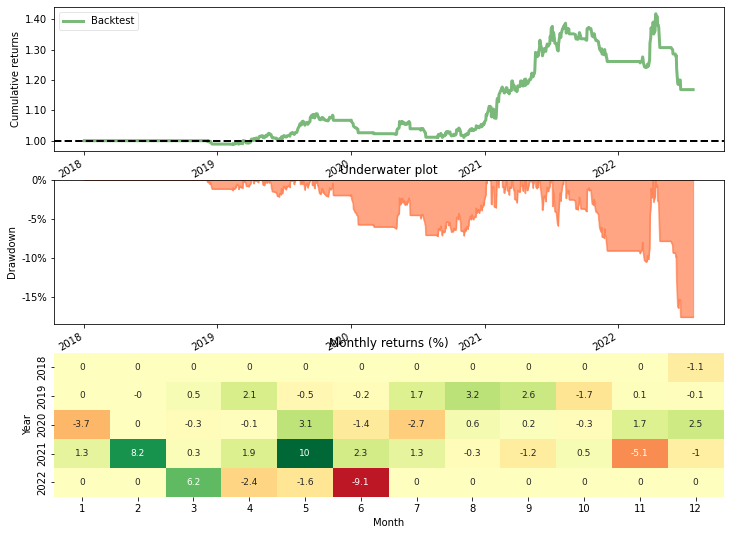

In [46]:
from stock_env.utils import create_performance
values = assetpf_signals.value()
values.index = df['time']
returns = values.pct_change()
create_performance(returns)

In [47]:
values.vbt.drawdowns.plot()

FigureWidget({
    'data': [{'line': {'color': '#1f77b4'},
              'showlegend': False,
              't…